# Backtesting

In [39]:
%matplotlib inline

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tushare as ts
from WindPy import *
import datetime
import time
import math 
from statsmodels import regression, stats
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%run final_project.py

matplotlib.rcParams["figure.figsize"] = (16, 9)

### 1. Get CSI 500 Index price information

In [2]:
tsapi = "4f025f8dd1a96fd251f95c75d65a1023db3a27f8c9f3bc964ebd51d9"
pro = ts.pro_api(tsapi)

In [3]:
df = pro.index_daily(ts_code='000905.SH', start_date='20180101', end_date='20190426')

In [4]:
converted_timestamp = pd.to_datetime(df["trade_date"], format="%Y-%m-%d")
df.index = converted_timestamp
df = df.drop(columns=["trade_date"])
df = df.sort_index()

In [5]:
df.tail()

,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2019-04-22,000905.SH,5723.0417,5821.0229,5824.5207,5704.9769,5810.1798,-87.1381,-1.4997,158161026.0,143410616.8
2019-04-23,000905.SH,5628.0624,5710.7334,5710.7334,5610.7353,5723.0417,-94.9793,-1.6596,149871461.0,133768248.9
2019-04-24,000905.SH,5679.7256,5636.4016,5682.4788,5568.4080,5628.0624,51.6632,0.9180,134784412.0,121970724.6
2019-04-25,000905.SH,5458.4194,5652.0056,5662.7898,5457.8254,5679.7256,-221.3062,-3.8964,151401718.0,132098714.9
2019-04-26,000905.SH,5408.0306,5427.6228,5496.0353,5407.1942,5458.4194,-50.3888,-0.9231,124279880.0,108970816.5


### 2. Compare the return of the index and our enhanced indexing strategy

2.1 Cumulative monthly return

In [21]:
test_return = pd.read_pickle("test_return.gz")

In [7]:
test_return["NEXT_RETURN"] = test_return["NEXT_RETURN"].cumsum() # strategy's cumulative return

In [8]:
test_return

,NEXT_RETURN
2018-01-31,-4.74539
2018-02-28,28.5398
2018-03-30,24.1962
2018-04-27,26.1281
2018-05-31,13.8019
2018-06-29,16.6309
2018-07-31,8.91487
2018-08-31,8.03425
2018-09-28,-3.5057
2018-10-31,6.82129


In [23]:
# calculate next month's returns of the index
dates = test_return.index
df_dates = df.loc[dates]
df_dates["NEXT_RETURN"] = (df_dates["close"] / df_dates["close"].shift(1) - 1) * 100
df_dates["NEXT_RETURN"] = df_dates["NEXT_RETURN"].shift(-1)
# add next month's return for the last month here
df_dates.iloc[-1, -1] = (df_dates.iloc[-1, 1] / df.iloc[-1, 1] - 1) * 100

In [10]:
df_dates["NEXT_RETURN"] = df_dates["NEXT_RETURN"].cumsum()  # index's cumulative return

In [11]:
df_dates["NEXT_RETURN"]

2018-01-31    -2.676606
2018-02-28    -1.164885
2018-03-30    -5.314770
2018-04-27    -7.132025
2018-05-31   -16.458859
2018-06-29   -17.015567
2018-07-31   -24.221451
2018-08-31   -24.514192
2018-09-28   -35.516208
2018-10-31   -33.079741
2018-11-30   -37.846280
2018-12-28   -37.643845
2019-01-31   -17.320064
2019-02-28    -6.925347
2019-03-29    -4.343529
Name: NEXT_RETURN, dtype: float64

In [12]:
diff = test_return["NEXT_RETURN"] - df_dates["NEXT_RETURN"] # difference between strategy's return and index's return

In [13]:
diff

2018-01-31   -2.06879
2018-02-28    29.7047
2018-03-30    29.5109
2018-04-27    33.2601
2018-05-31    30.2608
2018-06-29    33.6464
2018-07-31    33.1363
2018-08-31    32.5484
2018-09-28    32.0105
2018-10-31     39.901
2018-11-30    42.0834
2018-12-28    42.4797
2019-01-31    48.9255
2019-02-28    47.7454
2019-03-29    46.7241
Name: NEXT_RETURN, dtype: object

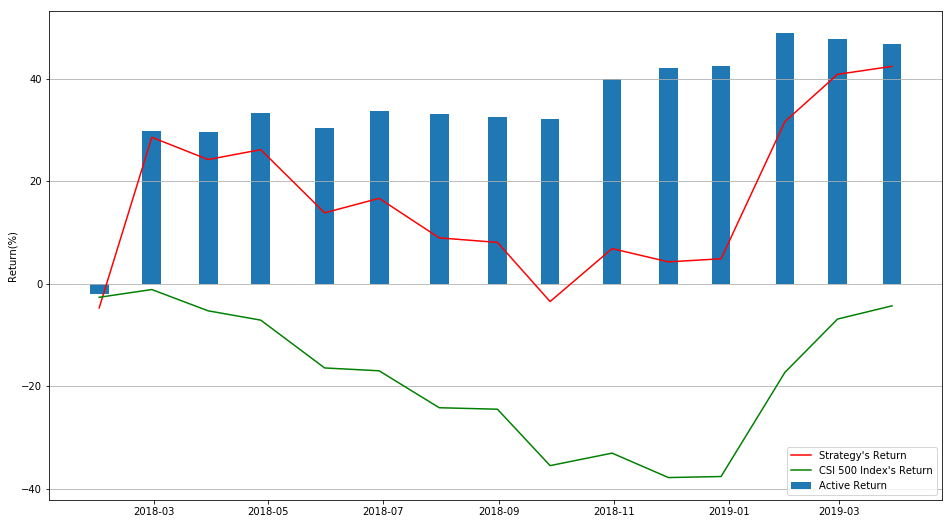

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(test_return["NEXT_RETURN"], "r-", label="Strategy's Return")
plt.plot(df_dates["NEXT_RETURN"], "g-", label="CSI 500 Index's Return")
plt.bar(diff.index, diff, width=10, label="Active Return")
plt.legend(loc="lower right")
plt.grid(axis="y")
plt.ylabel("Return(%)")
plt.savefig("backtesting.png")

2.2 Noncumulative monthly return

In [48]:
test_return

,strategy return
2018-01-31 00:00:00,-4.74539
2018-02-28 00:00:00,33.2852
2018-03-30 00:00:00,-4.34367
2018-04-27 00:00:00,1.93191
2018-05-31 00:00:00,-12.3262
2018-06-29 00:00:00,2.82897
2018-07-31 00:00:00,-7.71601
2018-08-31 00:00:00,-0.880618
2018-09-28 00:00:00,-11.5399
2018-10-31 00:00:00,10.327


In [49]:
df_dates["NEXT_RETURN"]

2018-01-31    -2.676606
2018-02-28     1.511721
2018-03-30    -4.149885
2018-04-27    -1.817255
2018-05-31    -9.326834
2018-06-29    -0.556708
2018-07-31    -7.205884
2018-08-31    -0.292742
2018-09-28   -11.002015
2018-10-31     2.436467
2018-11-30    -4.766539
2018-12-28     0.202436
2019-01-31    20.323781
2019-02-28    10.394717
2019-03-29     2.581818
Name: NEXT_RETURN, dtype: float64

In [31]:
test_return = test_return.rename(index=str, columns={"NEXT_RETURN": "strategy return"})
comp = pd.concat([test_return, df_dates["NEXT_RETURN"]], axis=1, join="outer")
comp = comp.rename(index=str, columns={"NEXT_RETURN": "index return"})
comp["diff"] = comp["strategy return"] - comp["index return"]

In [47]:
comp

,strategy return,index return,diff
2018-01-31 00:00:00,-4.74539,-2.676606,-2.06879
2018-02-28 00:00:00,33.2852,1.511721,31.7735
2018-03-30 00:00:00,-4.34367,-4.149885,-0.193786
2018-04-27 00:00:00,1.93191,-1.817255,3.74917
2018-05-31 00:00:00,-12.3262,-9.326834,-2.99934
2018-06-29 00:00:00,2.82897,-0.556708,3.38568
2018-07-31 00:00:00,-7.71601,-7.205884,-0.510125
2018-08-31 00:00:00,-0.880618,-0.292742,-0.587877
2018-09-28 00:00:00,-11.5399,-11.002015,-0.537933
2018-10-31 00:00:00,10.327,2.436467,7.89052


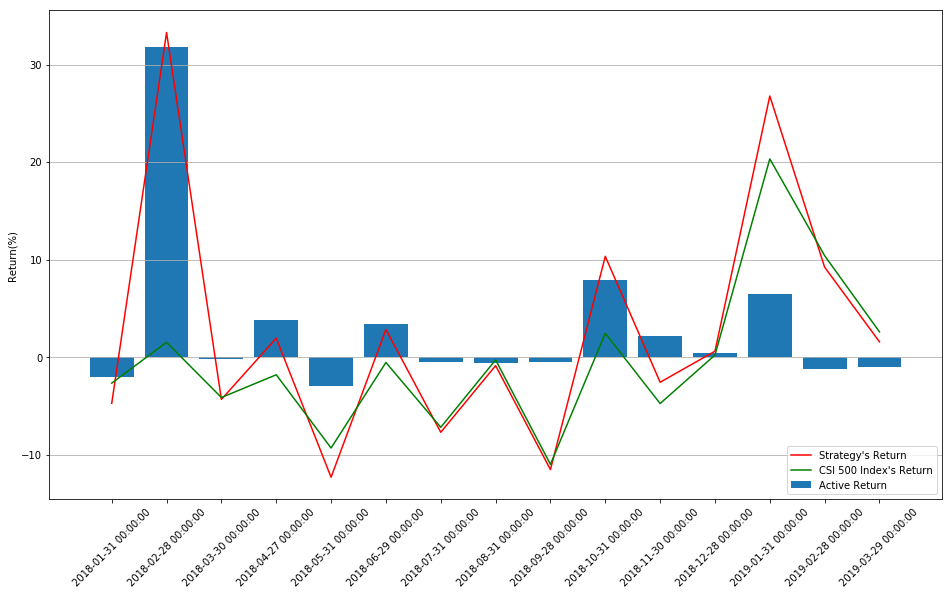

In [46]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(comp["strategy return"], "r-", label="Strategy's Return")
plt.plot(comp["index return"], "g-", label="CSI 500 Index's Return")
plt.bar(comp.index, comp["diff"], width=0.8, label="Active Return")
plt.legend(loc="lower right")
plt.grid(axis="y")
plt.ylabel("Return(%)")
plt.xticks(rotation=45)
plt.savefig("backtesting_noncumulative.png")